# Sistema de recomendação de produtos utilizando Deep Learning

-----------------------------

Os **sistemas de recomendação** desempenham um papel crucial em nosso mundo cada vez mais conectado e digital. Ao analisar o comportamento do usuário e as preferências individuais, esses sistemas têm a capacidade de oferecer sugestões personalizadas, seja em produtos, filmes, músicas ou conteúdo em geral. Essa abordagem não apenas melhora a experiência do usuário, tornando-a mais relevante e satisfatória, mas também permite que empresas e plataformas otimizem suas ofertas, aumentem o engajamento dos usuários e impulsionem o crescimento dos negócios. Através da inteligência das recomendações, os sistemas de recomendação desempenham um papel vital na facilitação da descoberta de novos interesses e na criação de uma experiência digital mais enriquecedora.

A **Filtragem Colaborativa Baseada em Item** é uma abordagem popular em sistemas de recomendação que se baseia nas preferências dos usuários por itens semelhantes. A ideia principal é que usuários que tiveram interações semelhantes com determinados itens também terão preferências semelhantes para outros itens similares. Dessa forma, a ideia principal dessa arquitetura de sistema de recomendação será classificar as classes dos produtos que o usuário está interagindo com uma rede neural, treinada com o Fashion MNIST. Após isso, recomendar um item similar ainda não visualizado pelo usuário que ele possa ter interesse. Nesse sistema de recomendação, o classificador profundo será essencial, pois a ideia é que só há imagens desse produtos sem a classe que ele pertence e, para automatizar essa identificação de classes, na melhor que uma rede neural profunda.

### Sobre o dataset Fashion MNIST
O conjunto de dados **Fashion MNIST** é composto por 70.000 imagens em escala de cinza, divididas em 60.000 imagens de treinamento e 10.000 imagens de teste. Cada imagem tem uma resolução de 28x28 pixels, totalizando 784 pixels por imagem. Cada pixel possui um valor inteiro entre 0 e 255, representando a intensidade de cinza, onde 0 significa preto e 255 significa branco.

### Objetivo do projeto
O **objetivo** deste projeto será treinar uma rede neural profunda para aprender os padrões das imagens de roupas e acessórios de moda do Fashion MNIST. Após esse algoritmo treinado, utiliza-lo dentro de um sistema de recomendação para sugerir produtos que sejam de interesse e semelhantes os pesquisados pelo cliente.

### Objetivos específicos
    - Analisar e estudar os dados do Fashion MNIST;
    - Selecionar o processamento de dados necessário para alimentar a rede neural; <======      
    - Arquitetar a rede neural de classificação;                                        ||
    - Treinar e validar a rede neural com as métrias de avaliação escolhidas;           ||
    - Avaliar o modelo; ==================================================================
    - Simular as pesquisas dos clientes com os dados de teste;
    - Criar o sistema de recomendação;
    - Avaliar o funcionamento dele;

In [1]:
# bibliotecas a serem utilziadas
import tensorflow as tf
import keras_tuner as kt
import json
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import base64

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels

## Importando e dividindo os dados do Fashion MNIST

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data() # importando do fashion mnist da biblioteca do tensorflow
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist # dividindo os dados em treino e teste

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.10, random_state=42) # 10% dos dados de treino para validação durante o treino

In [3]:
X_train.shape, X_train.dtype, y_train.dtype

((54000, 28, 28), dtype('uint8'), dtype('uint8'))

In [4]:
X_val.shape, X_val.dtype, y_val.dtype

((6000, 28, 28), dtype('uint8'), dtype('uint8'))

In [5]:
X_test.shape, X_test.dtype, y_test.dtype

((10000, 28, 28), dtype('uint8'), dtype('uint8'))

Como há uma quantidade significativa de dados, consegue-se ter uma divisão bem generosa em termos de quantidade. 

## Analisando os dados

----------------

Primeiramente, vou entender como as features e a variável alvo se comportam dentro do array dos dados de treino.

In [6]:
X_train.shape # 54 mil imagens de 28 de largura por 28 de altura

(54000, 28, 28)

In [7]:
print(f'Classe: {y_train[2]}'), X_train[2]  # objeto 2 dos dados de treino

Classe: 9


(None,
 array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   9,
          46,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0, 135, 198, 152,  70,   3,   0,   0,   1,   0,  30,
     

O objeto 2 dos dados de treino representa uma imagem, nele há **28 listas** com **28 valores cada** representando a altura e largura da imagem, respectivamente. Além disso, observa-se que esse objeto faz parte da **classe de produtos 9**.

Ainda, é possível observar que os pixels possuem **valores de 0 a 255**, que é uma ampla escala de valor, como dito na descrição do dataset. Por isso, **é necessário uma normalização** para ajudar no desempenho do modelo de rede neural.

-----------------------

Vou utilizar a função *imshow* do matplotlib para observar as imagens do dataset.

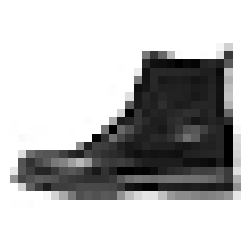

In [8]:
plt.figure(figsize=(3,3))
plt.imshow(X_train[2], cmap="binary") # binary converte os valores em escala de preto e branco
plt.axis('off')
plt.show()

Observa-se que são **imagens já pré-tratadas**, com processos de segmentação (fundo neutro e escala de cores reduzidas) e com baixa resolução (provavelmente reduzida sua dimensionaldiade) para deixar o conjunto mais leve em termos de armazenamento e mais fácil de ser processado. Apesar disso, o formato e pequenos detalhes são preservados dos produtos.

---------------------------------

Segundo a base de dados, essas são os respectivos nomes das lables numéricas:

- 0 T-shirt/top
- 1 Trouser
- 2 Pullover
- 3 Dress
- 4 Coat
- 5 Sandal
- 6 Shirt
- 7 Sneaker
- 8 Bag
- 9 Ankle boot

O diocionário abaixo servirá para informar o nome real da label quando necessário.

In [9]:
# {'label_encode':'label_nome'}
label_dict = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

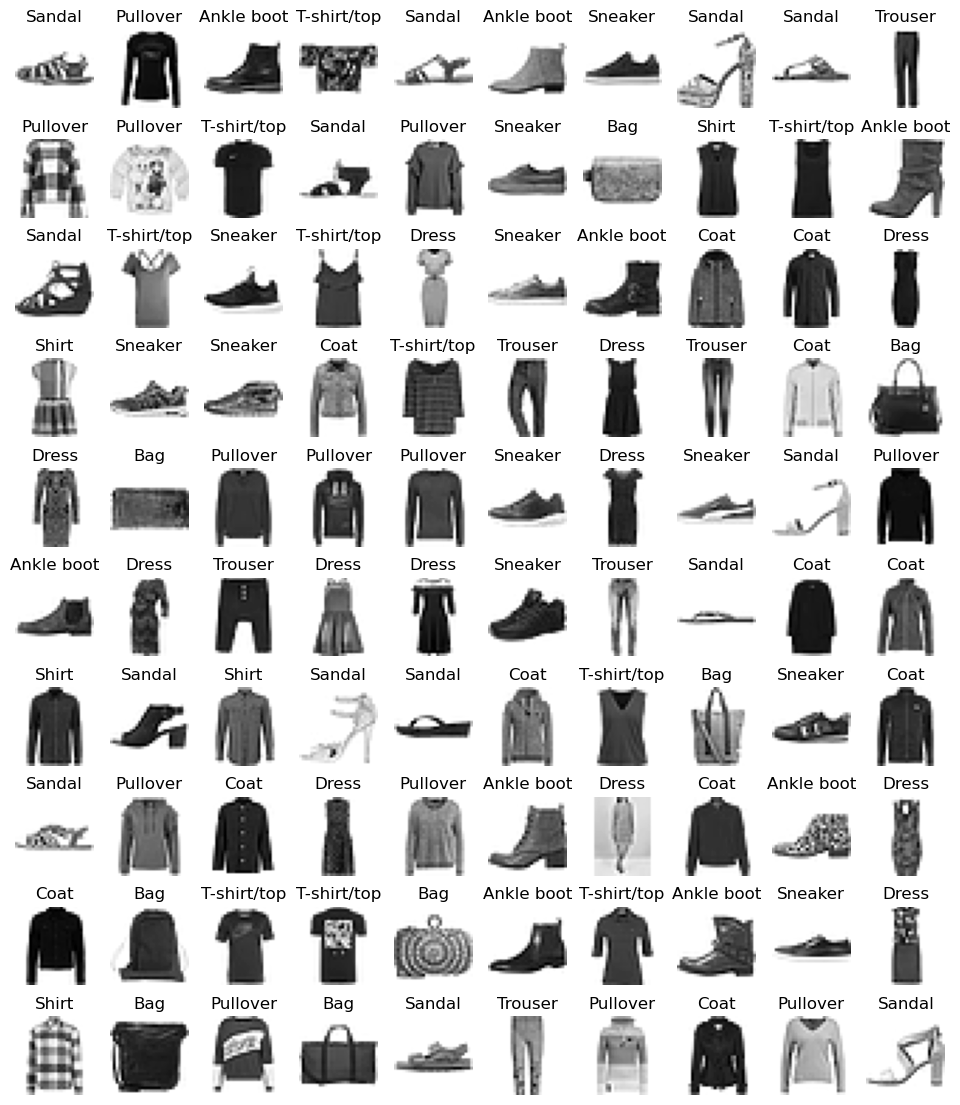

In [10]:
n_rows = 10 # figura 10x10 com 100 imagens do Fashion MNIST
n_cols = 10 

plt.figure(figsize=(n_rows*1.2, n_cols*1.4)) # tamanho da figura total
for row in range(n_rows):
    for col in range(n_cols):
        # "n_cols*row" permite que a cada linha de dez figuras o index de mantenha na dezena correspondente + número da coluna
        index = n_cols*row + col
        plt.subplot(n_rows, n_cols, index+1) # index+1 pois aceita valores de 1 <= valor <= 100
        plt.imshow(X_train[index], cmap='binary') # plot da figura correspondente
        plt.axis('off')
        plt.title(label_dict[y_train[index]]) # título com o nome da label correspondente a figura
plt.show()

Na Figura acima pode-se observar diversas imagens dos produtos com seus respectivos rótulos.

Nessa amostra, é possível identificar que para cada classe de label, há diversos produtos/imagens semelhantes mas distintos em algum aspecto da forma, textura e tonalidade. Um exemplo disso, são as sandálias "Sandal", que todas são "abertas", mas algumas possuem saltos, cores diferntes e formatos um pouco distintos.

As classes "shirt" e "coat" possuem muitas semelhanças e, por isso, acredito que podem ser até confundidas pelo modelo devido a complexidade da distinção.

## Pré-processamento de dados
---------------------

Como primeira análise, utilizarei apenas a normalização da intensidade em escala de cinza de 0 a 255 dos pixels fazendo a divisão de cada pixel por 255, que é seu máximo. Dessa forma, os valores de intensidade flutuarão entre 0 e 1.

Em primeira análise, será somente isso. Futuramente, de acordo com o desempenho do modelo, se houver necessidade irei revisar essa etapa e adicionar mais pré-processamentos. 

In [11]:
# função de normalização
def Normalization(X):
    return X.astype('float32')/255

In [12]:
X_train_full, X_train, X_val, X_test = Normalization(X_train_full), Normalization(X_train), Normalization(X_val), Normalization(X_test)

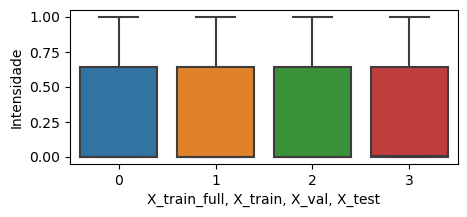

In [13]:
# boxplot
plt.figure(figsize=(5, 2))
sns.boxplot(data=[X_train_full, X_train, X_val, X_test])
plt.xlabel("X_train_full, X_train, X_val, X_test")
plt.ylabel("Intensidade")

plt.show()

Todos os dados estão entre 0 e 1, a normalização foif feita com sucesso.

---------------

## Arquitetura da rede neural

---------------------------

Para escolher a melhor arquitetura de uma forma um pouco mais automática, eu criarei uma função "build_model" que irá possibilitar a construção de diversos modelos. Após isso, irei utilizar a função "RandomSearch" da biblioteca "keras_tuner" para fazer a pesquisa do melhor modelo.

A função **ReLU** é uma simples função que retorna 0 se o valor x de entrada do neurônio for negativo e retorn x se x for positivo e é utilizada para mitigar o problema do gradiente desvanecente, o que a torna muito eficiente em termos de treinamento de redes neurais profundas. Já a função de ativação **Softmax** realiza uma transformação nos valores de saída da última camada da rede, para que eles possam ser interpretados como probabilidades das classes, por isso é utilizado muito para problemas de classificação.

Para começar, testarei uma arquitetura simples de duas camadas ocultas densas com função ReLu de ativação e uma final com 10 neurônios de saída com função de ativação Softmax. Além disso, utilizarem o otimizador **Adam**, visto que geralmente é uma comum escolha para se começar para atualizar os pesos da rede. Vou utilizar a perda **sparse categorical crossentropy** pois consegue lidar com variáveis encodadas não binárias.

Para evitar overfitting, pode-se aplicar a **regularização L2**, que ajuda a aplicar penalidades aos pesos durante o treinamento de uma rede neural. Ela ajuda a evitar que os pesos se tornem muito grandes e, assim, reduz o risco de overfitting.

In [14]:
X_train.shape[1:] # formato da entrada da rede neural

(28, 28)

Dos métodos de Keras Turner, "**Int**" faz uma busca entre os valores inteiros na faixa sugerida, "**Float**" o mesmo mas para flutuantes e "**Choice**" faz uma escolha exata dentre as opções sugeridas.

In [15]:
def build_model(hp): # hp = hiperparâmetro
    n_hidden_layers = hp.Int('n_hidden_layers', # opções de número de camadas ocultas
                             min_value=0, max_value=10,
                             default=2)
    n_neurons_layer = hp.Int('n_neurons_layer', # opções de número de neurônios por camada
                             min_value=16, max_value=304,
                             default=2)
    learning_rate = hp.Float('learning_rate', # opções de taxa de aprendizado do otimizador
                             min_value=1e-4, max_value=1e-2,
                             sampling='log') # 'log' faz uma amostragem mais densa para o valor mínimo
    optimizer = hp.Choice('optimizer', # opções de otimizadores
                         values=['sgd', 'adam'])
    regularizer = hp.Choice('regularizer', # opções de regularizadores
                                 values=['L1', 'L2', 'L1L2'])
    
    # escolha do regularizador
    if regularizer == 'L1':
        l1_lambda = hp.Float('l1_lambda', # força de regularização l1
                             min_value=1e-6, max_value=1e-4,
                             sampling='log')
        regularizer = tf.keras.regularizers.L1(l1_lambda)

    elif regularizer == 'L2':
        l2_lambda = hp.Float('l2_lambda', # força de regularização l2
                             min_value=1e-6, max_value=1e-4,
                             sampling='log')
        regularizer = tf.keras.regularizers.L2(l2_lambda)

    elif regularizer == 'L1L2':
        l1_lambda = hp.Float('l1_lambda', # força de regularização l1
                             min_value=1e-6, max_value=1e-4,
                             sampling='log')
        l2_lambda = hp.Float('l2_lambda', # força de regularização l2
                             min_value=1e-6, max_value=1e-4,
                             sampling='log')
        regularizer = tf.keras.regularizers.L1L2(l1=l1_lambda, l2=l2_lambda)

    # escolha do otimizador
    elif optimizer == 'sgd': 
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
        
    elif optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    model = tf.keras.Sequential() # arquiteta o modelo para uma rede neural sequencial
    model.add(tf.keras.layers.Flatten()) # camada para vetorizar a imagem 2D em 1D
    
    for _ in range(n_hidden_layers):
        model.add(tf.keras.layers.Dense(n_neurons_layer, activation='relu', kernel_regularizer=regularizer)) # camadas ocultas
    model.add(tf.keras.layers.Dense(10, activation="softmax", kernel_regularizer=regularizer)) # camada de saída
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, # compilagem
                  metrics=["accuracy"])
    
    return model

In [16]:
random_search_tuner = kt.RandomSearch(
    build_model, objective="val_accuracy", # o otimizador tentará maximizar a acurácia no conjunto de validação
    max_trials=20, # número máximo de tentativas de combinações diferentes
    overwrite=False, # substituir pesquisas anteriores
    directory='save_directory', project_name='randsearch_5', seed=42) # nome do diretório, nome do projeto e semente

random_search_tuner.search(X_train, y_train, epochs=15,
                           validation_data=(X_val, y_val))

INFO:tensorflow:Reloading Tuner from save_directory\randsearch_5\tuner0.json
INFO:tensorflow:Oracle triggered exit


In [17]:
best_hp = random_search_tuner.get_best_hyperparameters(num_trials=3)[0] # hiperparâmetros do melhor modelo
best_hp.values

{'n_hidden_layers': 2,
 'n_neurons_layer': 231,
 'learning_rate': 0.0003243806953412315,
 'optimizer': 'adam',
 'regularizer': 'L1L2',
 'l1_lambda': 5.070370705614628e-06,
 'l2_lambda': 4.448908237159881e-06}

In [18]:
model = build_model(best_hp) # construindo o modelo ideal utilizando os melhores hiperparâmetroscom com o construtor

## Treino, validação e escolha do melhor modelo

------------------

Nesta etapa se fará os treinos dos melhores modelos encontrados através do Random Search do Keras Tuner. Após isso, é feita a análise de desempenho para cada um desses modelos e, em seguida, feita novas modificações e testes, escolhido outro melhor modelo e o procedimento é repetido até surgir um modelo ótimo ou não surgir mudanças a partir de novas modificações.

In [19]:
tf.random.set_seed(42)
optimizer = tf.keras.optimizers.Adam(learning_rate=best_hp.values['learning_rate'])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10), # patience são as épocas consecutivas permitidas sem melhora no desempenho
    tf.keras.callbacks.ModelCheckpoint('callbacks/sisreco_six', save_best_only=True, save_weights_only=False), # salvará o modelo
]

history = model.fit(X_train, y_train, epochs=200,
                        validation_data=(X_val, y_val),
                        callbacks=callbacks)

Epoch 1/200
1681/1688 [============================>.] - ETA: 0s - loss: 0.5645 - accuracy: 0.8207INFO:tensorflow:Assets written to: callbacks\sisreco_six\assets


INFO:tensorflow:Assets written to: callbacks\sisreco_six\assets


1688/1688 [==============================] - 9s 5ms/step - loss: 0.5640 - accuracy: 0.8209 - val_loss: 0.4497 - val_accuracy: 0.8602
Epoch 2/200
1678/1688 [============================>.] - ETA: 0s - loss: 0.4214 - accuracy: 0.8677INFO:tensorflow:Assets written to: callbacks\sisreco_six\assets


INFO:tensorflow:Assets written to: callbacks\sisreco_six\assets


1688/1688 [==============================] - 8s 5ms/step - loss: 0.4211 - accuracy: 0.8679 - val_loss: 0.4232 - val_accuracy: 0.8625
Epoch 3/200
1678/1688 [============================>.] - ETA: 0s - loss: 0.3808 - accuracy: 0.8795INFO:tensorflow:Assets written to: callbacks\sisreco_six\assets


INFO:tensorflow:Assets written to: callbacks\sisreco_six\assets


1688/1688 [==============================] - 8s 5ms/step - loss: 0.3805 - accuracy: 0.8795 - val_loss: 0.3987 - val_accuracy: 0.8767
Epoch 4/200
1686/1688 [============================>.] - ETA: 0s - loss: 0.3568 - accuracy: 0.8881INFO:tensorflow:Assets written to: callbacks\sisreco_six\assets


INFO:tensorflow:Assets written to: callbacks\sisreco_six\assets


1688/1688 [==============================] - 8s 5ms/step - loss: 0.3571 - accuracy: 0.8880 - val_loss: 0.3750 - val_accuracy: 0.8810
Epoch 5/200
1688/1688 [==============================] - 7s 4ms/step - loss: 0.3373 - accuracy: 0.8932 - val_loss: 0.3856 - val_accuracy: 0.8750
Epoch 6/200
1688/1688 [==============================] - ETA: 0s - loss: 0.3212 - accuracy: 0.8999INFO:tensorflow:Assets written to: callbacks\sisreco_six\assets


INFO:tensorflow:Assets written to: callbacks\sisreco_six\assets


1688/1688 [==============================] - 8s 5ms/step - loss: 0.3212 - accuracy: 0.8999 - val_loss: 0.3749 - val_accuracy: 0.8815
Epoch 7/200
1682/1688 [============================>.] - ETA: 0s - loss: 0.3093 - accuracy: 0.9040INFO:tensorflow:Assets written to: callbacks\sisreco_six\assets


INFO:tensorflow:Assets written to: callbacks\sisreco_six\assets


1688/1688 [==============================] - 8s 5ms/step - loss: 0.3094 - accuracy: 0.9040 - val_loss: 0.3714 - val_accuracy: 0.8835
Epoch 8/200
1686/1688 [============================>.] - ETA: 0s - loss: 0.2995 - accuracy: 0.9082INFO:tensorflow:Assets written to: callbacks\sisreco_six\assets


INFO:tensorflow:Assets written to: callbacks\sisreco_six\assets


1688/1688 [==============================] - 8s 5ms/step - loss: 0.2995 - accuracy: 0.9081 - val_loss: 0.3652 - val_accuracy: 0.8872
Epoch 9/200
1688/1688 [==============================] - 6s 4ms/step - loss: 0.2900 - accuracy: 0.9106 - val_loss: 0.3737 - val_accuracy: 0.8833
Epoch 10/200
1688/1688 [==============================] - 7s 4ms/step - loss: 0.2821 - accuracy: 0.9138 - val_loss: 0.3676 - val_accuracy: 0.8888
Epoch 11/200
1674/1688 [============================>.] - ETA: 0s - loss: 0.2733 - accuracy: 0.9177INFO:tensorflow:Assets written to: callbacks\sisreco_six\assets


INFO:tensorflow:Assets written to: callbacks\sisreco_six\assets


1688/1688 [==============================] - 7s 4ms/step - loss: 0.2734 - accuracy: 0.9176 - val_loss: 0.3637 - val_accuracy: 0.8865
Epoch 12/200
1684/1688 [============================>.] - ETA: 0s - loss: 0.2654 - accuracy: 0.9198INFO:tensorflow:Assets written to: callbacks\sisreco_six\assets


INFO:tensorflow:Assets written to: callbacks\sisreco_six\assets


1688/1688 [==============================] - 7s 4ms/step - loss: 0.2653 - accuracy: 0.9198 - val_loss: 0.3550 - val_accuracy: 0.8942
Epoch 13/200
1688/1688 [==============================] - 7s 4ms/step - loss: 0.2577 - accuracy: 0.9236 - val_loss: 0.3561 - val_accuracy: 0.8927
Epoch 14/200
1688/1688 [==============================] - 8s 5ms/step - loss: 0.2504 - accuracy: 0.9256 - val_loss: 0.3582 - val_accuracy: 0.8943
Epoch 15/200
1688/1688 [==============================] - 7s 4ms/step - loss: 0.2448 - accuracy: 0.9284 - val_loss: 0.3689 - val_accuracy: 0.8928
Epoch 16/200
1682/1688 [============================>.] - ETA: 0s - loss: 0.2397 - accuracy: 0.9301INFO:tensorflow:Assets written to: callbacks\sisreco_six\assets


INFO:tensorflow:Assets written to: callbacks\sisreco_six\assets


1688/1688 [==============================] - 9s 5ms/step - loss: 0.2398 - accuracy: 0.9301 - val_loss: 0.3513 - val_accuracy: 0.8960
Epoch 17/200
1688/1688 [==============================] - 6s 4ms/step - loss: 0.2332 - accuracy: 0.9323 - val_loss: 0.3676 - val_accuracy: 0.8920
Epoch 18/200
1688/1688 [==============================] - 7s 4ms/step - loss: 0.2282 - accuracy: 0.9349 - val_loss: 0.3582 - val_accuracy: 0.8922
Epoch 19/200
1688/1688 [==============================] - 7s 4ms/step - loss: 0.2229 - accuracy: 0.9376 - val_loss: 0.3792 - val_accuracy: 0.8878
Epoch 20/200
1688/1688 [==============================] - 6s 4ms/step - loss: 0.2177 - accuracy: 0.9389 - val_loss: 0.3548 - val_accuracy: 0.8943
Epoch 21/200
1688/1688 [==============================] - 7s 4ms/step - loss: 0.2137 - accuracy: 0.9416 - val_loss: 0.3742 - val_accuracy: 0.8962
Epoch 22/200
1688/1688 [==============================] - 7s 4ms/step - loss: 0.2090 - accuracy: 0.9430 - val_loss: 0.3700 - val_accuracy

In [20]:
# função para salvar e carregar history de modelos em json
def save_load_history(directory, action, history=None):
    '''action: 'w' para escrever/salvar e 'r' para ler/load'''
    if action == 'w':
        dict_json = {}
        dict_json['history'] = history.history
        dict_json['epoch'] = history.epoch
        history_json = json.dumps(dict_json)
        with open(directory, action) as f:
            f.write(history_json)
            
    else:
        with open(directory, action) as f:
            history_json = f.read()
        history = json.loads(history_json)
        return history

In [21]:
# salvar os historys dos melhores modelos
#save_load_history('best_modelos\history\history_model_3.json', 'w', history=history)

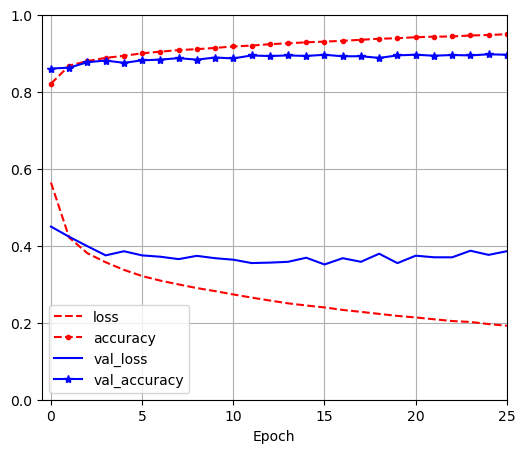

In [22]:
plt.figure(figsize=(6,5))
for key, style in zip(history.history, ["r--", "r--.", "b-", "b-*"]):
    epochs = np.array(history.epoch)
    plt.plot(epochs, history.history[key], style, label=key)
plt.xlabel("Epoch")
plt.axis([-0.5, epochs.max(), 0., 1])
plt.legend(loc="lower left")
plt.grid()
plt.show()

### Análise experimental

**0 check de avaliação**: 

Uma patience na parada antecipada de 25 está levando o modelo a treinar e muitas épocas (cerca de 180) e está levando o modelo ao overfitting, visto que a loss de validação está aumentando conforme as épocas. A acurácia de validação fica a 89,46% (um desempenho bom), enquanto a de treino chega próxima do 100%, o que confirma que há overfitting no modelo. Dessa forma, buscarei reduzir o número de patience da parada antecipada.

**1º check de avaliação**: loss: 0.0698 - accuracy: 0.9753 - val_loss: 0.6319 - val_accuracy: 0.8943

Uma patience de 10 o modelo está treinando em apenas 12 épocas com acurácia de validação de 89,43% (muito bom comparado ao número de épocas anteriores). Além disso, há loss de validação está mais estável, mas ainda muito distante da loss de treino, o que indica overfitting, além da própria diferença da acurácia d treino.

**2º check de avaliação**: *loss: 0.2312 - accuracy: 0.9206 - val_loss: 0.3656 - val_accuracy: 0.8927*

{'n_hidden_layers': 4,
 'n_neurons_layer': 279,
 'learning_rate': 0.0012405181050498832,
 'optimizer': 'adam',
 'l2_lambda': 5.51046971951964e-06,
 'regularizer': 'L1',
 'l1_lambda': 1e-06}

Adicionei a regularização L2 em todas camadas, com isso a loss, tanto da validação quando do treino, se aproximaram e o mesmo ocorreu para a acurácia. Isso validou a redução do overfitting, contudo, perdeu-se decimais de acurácia, mas ganhou-se um modelo com maior capacidade de generalização.

**3º check de avaliação**: loss: 0.2256 - accuracy: 0.9243 - val_loss: 0.3610 - val_accuracy: 0.8868

Retirei a L2 da camada de saída. De uma maneira geral, é possível afirmar que o modelo piorou comparado ao anterior.

**4º check de avaliação**: *loss: 0.2363 - accuracy: 0.9309 - val_loss: 0.3779 - val_accuracy: 0.8903* 

{'n_hidden_layers': 2,
 'n_neurons_layer': 231,
 'learning_rate': 0.0003243806953412315,
 'optimizer': 'adam',
 'regularizer': 'L1L2',
 'l1_lambda': 5.070370705614628e-06,
 'l2_lambda': 4.448908237159881e-06}

Adicionando L1 e L1L2 aos regularizadores, o RandomSearch escolheu o L1L2 como melhor regularizador. Nesse modelo, o regularizador não está presente na camada de saída. Ademais, o modelo 4 apresentou melhoras na acurácia e na perda comparado ao 3, o que pode-se concluir que o regularizador L1L2 apresentou melhora.

**5º check de avaliação**: loss: 0.2093 - accuracy: 0.9432 - val_loss: 0.3847 - val_accuracy: 0.8960:

{'n_hidden_layers': 2,
 'n_neurons_layer': 231,
 'learning_rate': 0.0003243806953412315,
 'optimizer': 'adam',
 'regularizer': 'L1L2',
 'l1_lambda': 5.070370705614628e-06,
 'l2_lambda': 4.448908237159881e-06}

Essa aqui tem uma regularização L1L2 na camada da saída. No geral, apresentou um desempenho similar ao do check 4 e 2, melhor em algumas métricas e piores em outras.

---------------------

- Após evoluir durante a experimentação e testar diversas arquiteturas de modelo, percebi que o que mais contribuiu para o desempenho do modelo foi a implementação da regularização, que reduziu muito o overfitting. Ademais, as regularizações L2 e L1L2 foram as que em todos os melhores modelos de cada modificação, aprestaram melhor performance;
- Apesar das mudanças, consegui apenas reduzir o overfitting, mas não aumentar a acurácia geral do modelo com as aplicações;
- Analisando, os modelos que apresentaram melhor modelo foi o do **2º check**, **4º check** e do **5º check**;

--------------------------------------

Os dois melhores modelos serão analisados em gráfico com matplotlib como o gráfico anterior. O modelo referente ao **2º check** será salvo como *model_1*, o referente ao **4º check** como *modelo_2* e ao **5º check** como *modelo_3*.

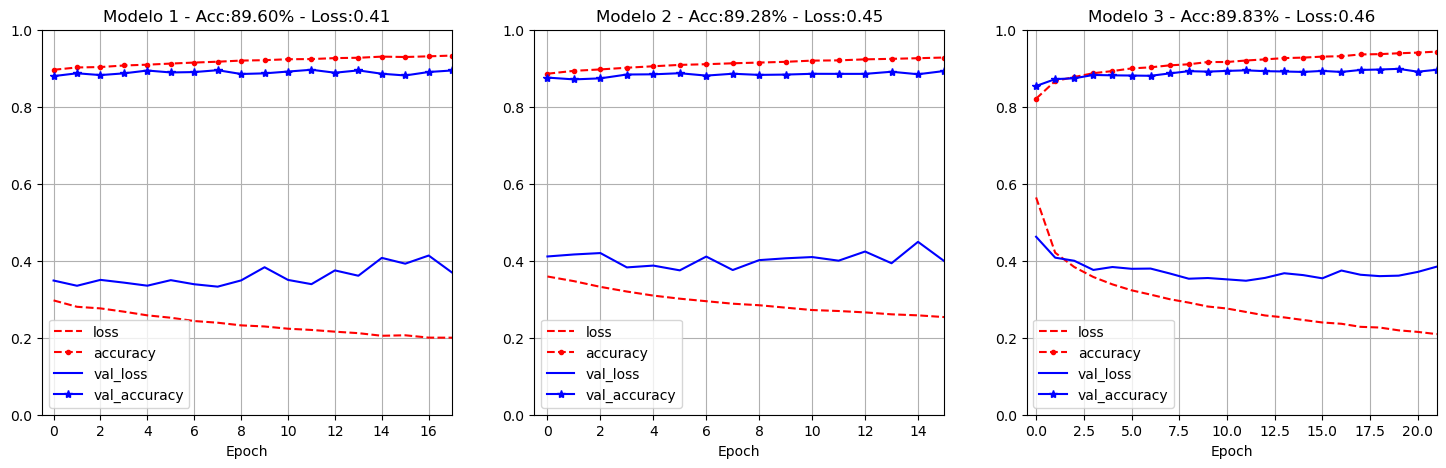

In [23]:
# criando lista de historys para plotar e analisar os modelos
historys_models = []
for i in range(3):
    history_model = save_load_history(f'best_modelos\history\history_model_{i+1}.json', 'r') # carregar historys
    historys_models.append(history_model)

plt.figure(figsize=(18, 5))
for i, history in enumerate(historys_models):
    plt.subplot(1,3, i+1)
    # relacionando cada chave de dicionário a uma estilo de linha de plot e fazendo o unpacking
    for key, style in zip(history['history'], ["r--", "r--.", "b-", "b-*"]): 
        epochs = np.array(history['epoch'])
        plt.plot(epochs, history['history'][key], style, label=key) # plot dos valores das métricas por época
    plt.title(f"Modelo {i+1} - Acc:{np.max(history['history']['val_accuracy']):.2%} - Loss:{np.max(history['history']['val_loss']):.2f}")
    plt.xlabel("Epoch")
    plt.axis([-0.5, epochs.max(), 0., 1]) # formatando eixos
    plt.legend(loc="lower left")
    plt.grid()

plt.show()

- O Modelo 1  e 2 treinaram em um pouco menos épocas que o 3.
- Em uma **análise qualitativa visual**, não há um modelo claramente superior em *termos de acurácia* e o aumento da mesma durante o treinamento, no geral se comportam de maneira semelhante, onde apenas o modelo 3 apresenta um início um pouco diferente.
- Em *termos de loss*, **visualmente** nenhum modelo possui grande diferença dos demais. No entanto, o Modelo 3 apresentou maior estabilidade na loss de validação durante o treinamento, que indica: menos sensibilidade a flutuações nos dados, promovendo maior confiança; sugere que ele está encontrando uma solução mais adequada, que melhor se ajuste; possui menos probabilidade de sofrer overfitting, possuindo melhor generalização. Apesar disso, o modelo 1 e 2 não possui oscilações grotescas, essa análise feita leva como referência apenas a comparação entre os resultados obtidos.
- **Quantitativamente**, o Modelo 3 apresentou maior acurácia e maior perda de validação, em seguida o Modelo 1, com uma acurácia um pouco menor e menor perda dos três. O Modelo 2, qualitativamente, apresentou pior resultado. Apesar disso, nenhum modelo apresentou grande vantagem/desvantagem sobre os outros;


A partir das análises feitas, o **Modelo 3** vai ser escolhido, principalmente pela sua superior acurácia na validação comparada aos demais e estabilidade na loss de validação.

---------------------------------------

## Treino e avaliação do melhor modelo

-----------------------------------

Nessa etapa, o modelo será **treinado com os dados completos** e **avaliado com os dados de teste**. Como estamos treinando o modelo utilizando os dados completos (X_train_full e y_train_full), *não temos um conjunto de validação* separado para monitorar a melhoria da métrica durante o treinamento. Como resultado, a técnica de **parada antecipada não será efetiva** nesse caso, e o treinamento acontecerá na mesma quantidade de épocas em que ocorreu o treino e validação, ou seja, **21 épocas**.

In [24]:
best_model = tf.keras.models.load_model("callbacks/sisreco_five") # chamando Modelo 3

tf.random.set_seed(42)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003243806953412315) # learning rate descrito em check 5
best_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

best_history = best_model.fit(X_train_full, y_train_full, epochs=21) # treinamento com dados completos

Epoch 1/21
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2299 - accuracy: 0.9360
Epoch 2/21
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2197 - accuracy: 0.9394
Epoch 3/21
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2149 - accuracy: 0.9409
Epoch 4/21
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2100 - accuracy: 0.9438
Epoch 5/21
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2069 - accuracy: 0.9444
Epoch 6/21
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2010 - accuracy: 0.9460
Epoch 7/21
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1996 - accuracy: 0.9479
Epoch 8/21
1875/1875 [==============================] - 8s 5ms/step - loss: 0.1929 - accuracy: 0.9496
Epoch 9/21
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1901 - accuracy: 0.9519
Epoch 10/21
1875/1875 [==============================] - 11s 6ms/step - loss: 0.18

In [25]:
# salvando o modelo em formato tensorflow
#best_model.save("callbacks/best_model_five", save_format="tf")

In [26]:
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.4422 - accuracy: 0.8982


- A acurácia e a perda na avaliação dos dados de teste tiveram uma perda de desempenho comparado aos obtidos na validação. Apesar disso, considerando que os dados de validação são praticamente a metade dos de teste e podem não representar tão bem o cenário global, foi uma perda aceitável de performance.

In [27]:
y_proba = best_model.predict(X_test) # retorna 10 probabilidades de uma instância pertencer a uma classe
y_pred = y_proba.argmax(axis=-1) # retorna o índice da maior probabilidade, esse índice é equivalente a label predita

313/313 [==============================] - 1s 2ms/step


In [28]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8337    0.8620    0.8476      1000
           1     0.9859    0.9800    0.9829      1000
           2     0.8514    0.8020    0.8260      1000
           3     0.8951    0.9220    0.9084      1000
           4     0.8080    0.8500    0.8285      1000
           5     0.9767    0.9660    0.9713      1000
           6     0.7484    0.7080    0.7276      1000
           7     0.9477    0.9600    0.9538      1000
           8     0.9760    0.9740    0.9750      1000
           9     0.9561    0.9580    0.9570      1000

    accuracy                         0.8982     10000
   macro avg     0.8979    0.8982    0.8978     10000
weighted avg     0.8979    0.8982    0.8978     10000



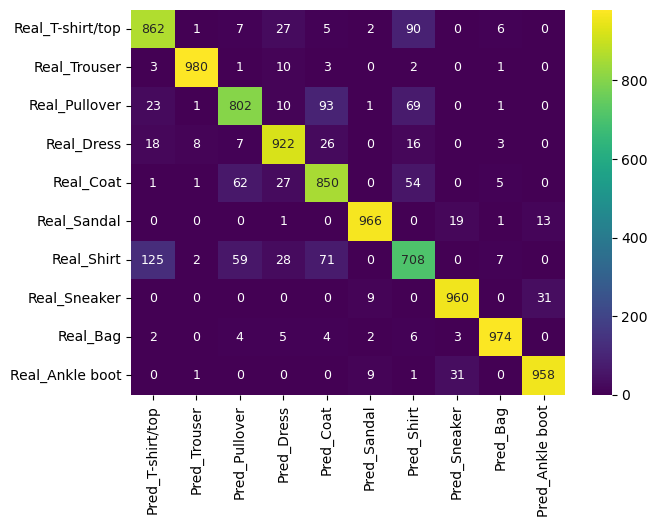

In [29]:
plt.figure(figsize=(7,5))

labels = unique_labels(y_test) # retorna um array de labels
column = [f'Pred_{label_dict[label]}' for label in labels] # nomes personalizados para as predições
indices = [f'Real_{label_dict[label]}' for label in labels] # nomes personalizados para os dados reais
tabela = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=column, index=indices) # dataframe da matriz de confusão
sns.heatmap(data=tabela, annot=True, fmt='d', cmap='viridis', annot_kws={'size': 9}) # plot da matriz de confusão no heatmap

plt.show()

- Diversas classes apresentaram um excelente F1-Score, ao redor e até acima de 95%, o que é excelente. Apesar disso, há 4 classes que estão constribuindo para a queda no desempenho do modelo, que são:

    - **'T-shirt/top'**(0) com *85%*;
    - **'Pullover'**(2) com *78%*;
    - **'Coat'**(4) com *81%*;
    - **'Shirt'**(6) com *72%*.

--------------

Muitas **Shirts** *estão sendo confundidas com* **T-shirt/top** e elas realmente são parecidas, não me surpreendo nem um pouco em serem confundidas. Além disso, **Shirts** também *estão sendo confundidas com* **Pullover** e **Coat**, que também são similares. **Vice-versa acontece da mesma forma** e essas classes se auto-confundem, umas mais e outras menos, o que faz com que a performance delas seja reduzida.

Apesar de um desempenho individual inferior de algumas classes comparados ao geral, essas classes ainda possuem um desempenho relativamente satisfatório e **não irão prejudicar signficativamente no sistema de recomendação**, o que é o mais importante.

-------------------------

## Simulando as pesquisas dos clientes

-----------------

No total, há 10 mil dados de testes e uma parcela deles serão utilizados para simular as interações. Essas interações serão projetadas em uma lista de imagens, onde cada lista será correspondente a um cliente e suas interações.

In [30]:
# simulando aleatoriamente interações de usuários com produtos
interacoes_lista = []
for _ in range(10): # 10 clientes
    n_iteracoes = np.random.choice(range(13,22), 1, replace=False) # gerador aleatório para número de iterações por cliente
    random_index = np.random.choice(len(X_test), n_iteracoes, replace=False) # gerando índices aleatórios
    random_produtos = X_test[random_index] # pegando produtos correspondentes aos índices
    interacoes_lista.append(random_produtos)
    
interacoes_clientes = np.array(interacoes_lista, dtype=object)

Agora nas interações há 20 interações de clientes de tamanhos diferentes. Cada lista pronta para ser predita pela rede neural.

-------------------

## Arquitetura e teste do sistema de recomendação

----------------

A ideia será fazer uma função que recebe as interações do cliente e um modelo de predição. Após isso, é feita a predição das imagens dos produtos que o cliente interagiu e, em seguida, é aplicada um método estatístico baseado em frequência da classe de produto que o usuário mais interagiu. Com isso, o sistema escolhe um produto aleatório de mesma classe ainda não visualizado pelo cliente e finalmente, emite uma mensagem personalizada para ele com o produto recomendado.

In [32]:
# função do sistema de recomendação
def sistema_de_recomendacao(interacoes_cliente, model):
    label_dict = {
        0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat',
        5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}
    
    # predição
    y_pred = model.predict(interacoes_cliente, verbose=0).argmax(axis=-1)

    # escolha do produto a recomendar para o cliente
    mais_freq = np.bincount(y_pred).argmax() # retorna a classe de produtos mais frequentes
    prod_reco_index = np.random.choice(np.where(y_train == mais_freq)[0], 1, replace=False) # indice de produto similar
    prod_recomendado = X_train[prod_reco_index][0]
    nome_prod_recomendado = label_dict[mais_freq]
    
    # mensagem personalizada
    print(f"Olá! De uma olhada nesse(a) {nome_prod_recomendado} que separamos exclusivamente para você:")
    
    plt.figure(figsize=(1.5, 1.5))
    plt.imshow(prod_recomendado, cmap='binary') # plotar a imagem do produto sugerido
    plt.axis('off')
    plt.show()
        
    descricao_prod = {
        'T-shirt/top': "Essa camiseta moderna e estilosa é perfeita para o seu dia a dia. Ela combina conforto e elegância, sendo versátil para diversas ocasiões.",
        'Trouser': "Nossa calça é um clássico da moda, ideal para looks casuais e formais. Confeccionada com tecido de alta qualidade, proporciona um caimento impecável.",
        'Pullover': "O pulôver é uma peça indispensável no inverno. Esse modelo, com design exclusivo, mantém você quentinho e cheio de estilo durante a estação.",
        'Dress': "Este vestido encantador vai tornar você o centro das atenções em qualquer evento. Com um toque delicado e sofisticado, é a escolha perfeita para ocasiões especiais.",
        'Coat': "Nosso casaco elegante e confortável é a peça ideal para enfrentar os dias frios com muito estilo. Ele é uma combinação perfeita entre moda e funcionalidade.",
        'Sandal': "Essa sandália é a companhia perfeita para o verão. Confortável e estilosa, ela combina com diversos looks, proporcionando frescor e elegância.",
        'Shirt': "Essa camisa é um clássico que nunca sai de moda. Com um corte impecável e acabamento de alta qualidade, ela é perfeita para ocasiões formais.",
        'Sneaker': "O tênis esportivo é ideal para quem busca conforto e estilo no dia a dia. Com um design moderno e tecnologia avançada, esse tênis vai te surpreender.",
        'Bag': "Essa bolsa é o acessório indispensável para completar seu look. Com um design elegante e espaçoso, ela é perfeita para carregar todos os seus itens essenciais.",
        'Ankle boot': "Essa bota é a combinação perfeita de estilo e conforto. Versátil e moderna, ela é ideal para criar looks descolados em qualquer estação do ano."
    }

    print(f'{descricao_prod[nome_prod_recomendado]}\n')
    print('Esperamos que você goste do nosso produto! Aproveite e faça sua compra hoje mesmo.')
    print("Qualquer dúvida, entre em contato conosco. Estamos sempre prontos para ajudar!\n")

Olá! De uma olhada nesse(a) Bag que separamos exclusivamente para você:


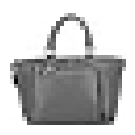

Essa bolsa é o acessório indispensável para completar seu look. Com um design elegante e espaçoso, ela é perfeita para carregar todos os seus itens essenciais.

Esperamos que você goste do nosso produto! Aproveite e faça sua compra hoje mesmo.
Qualquer dúvida, entre em contato conosco. Estamos sempre prontos para ajudar!

----------------------------------------------------------------------------------------------------------------------------- 

Olá! De uma olhada nesse(a) Sneaker que separamos exclusivamente para você:


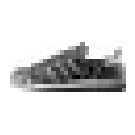

O tênis esportivo é ideal para quem busca conforto e estilo no dia a dia. Com um design moderno e tecnologia avançada, esse tênis vai te surpreender.

Esperamos que você goste do nosso produto! Aproveite e faça sua compra hoje mesmo.
Qualquer dúvida, entre em contato conosco. Estamos sempre prontos para ajudar!

----------------------------------------------------------------------------------------------------------------------------- 

Olá! De uma olhada nesse(a) Dress que separamos exclusivamente para você:


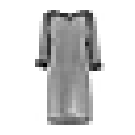

Este vestido encantador vai tornar você o centro das atenções em qualquer evento. Com um toque delicado e sofisticado, é a escolha perfeita para ocasiões especiais.

Esperamos que você goste do nosso produto! Aproveite e faça sua compra hoje mesmo.
Qualquer dúvida, entre em contato conosco. Estamos sempre prontos para ajudar!

----------------------------------------------------------------------------------------------------------------------------- 

Olá! De uma olhada nesse(a) Coat que separamos exclusivamente para você:


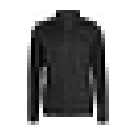

Nosso casaco elegante e confortável é a peça ideal para enfrentar os dias frios com muito estilo. Ele é uma combinação perfeita entre moda e funcionalidade.

Esperamos que você goste do nosso produto! Aproveite e faça sua compra hoje mesmo.
Qualquer dúvida, entre em contato conosco. Estamos sempre prontos para ajudar!

----------------------------------------------------------------------------------------------------------------------------- 

Olá! De uma olhada nesse(a) Sandal que separamos exclusivamente para você:


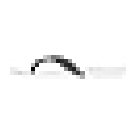

Essa sandália é a companhia perfeita para o verão. Confortável e estilosa, ela combina com diversos looks, proporcionando frescor e elegância.

Esperamos que você goste do nosso produto! Aproveite e faça sua compra hoje mesmo.
Qualquer dúvida, entre em contato conosco. Estamos sempre prontos para ajudar!

----------------------------------------------------------------------------------------------------------------------------- 

Olá! De uma olhada nesse(a) Trouser que separamos exclusivamente para você:


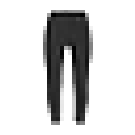

Nossa calça é um clássico da moda, ideal para looks casuais e formais. Confeccionada com tecido de alta qualidade, proporciona um caimento impecável.

Esperamos que você goste do nosso produto! Aproveite e faça sua compra hoje mesmo.
Qualquer dúvida, entre em contato conosco. Estamos sempre prontos para ajudar!

----------------------------------------------------------------------------------------------------------------------------- 

Olá! De uma olhada nesse(a) Dress que separamos exclusivamente para você:


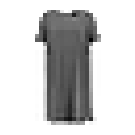

Este vestido encantador vai tornar você o centro das atenções em qualquer evento. Com um toque delicado e sofisticado, é a escolha perfeita para ocasiões especiais.

Esperamos que você goste do nosso produto! Aproveite e faça sua compra hoje mesmo.
Qualquer dúvida, entre em contato conosco. Estamos sempre prontos para ajudar!

----------------------------------------------------------------------------------------------------------------------------- 

Olá! De uma olhada nesse(a) Dress que separamos exclusivamente para você:


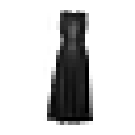

Este vestido encantador vai tornar você o centro das atenções em qualquer evento. Com um toque delicado e sofisticado, é a escolha perfeita para ocasiões especiais.

Esperamos que você goste do nosso produto! Aproveite e faça sua compra hoje mesmo.
Qualquer dúvida, entre em contato conosco. Estamos sempre prontos para ajudar!

----------------------------------------------------------------------------------------------------------------------------- 

Olá! De uma olhada nesse(a) Trouser que separamos exclusivamente para você:


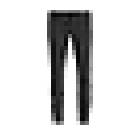

Nossa calça é um clássico da moda, ideal para looks casuais e formais. Confeccionada com tecido de alta qualidade, proporciona um caimento impecável.

Esperamos que você goste do nosso produto! Aproveite e faça sua compra hoje mesmo.
Qualquer dúvida, entre em contato conosco. Estamos sempre prontos para ajudar!

----------------------------------------------------------------------------------------------------------------------------- 

Olá! De uma olhada nesse(a) Dress que separamos exclusivamente para você:


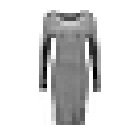

Este vestido encantador vai tornar você o centro das atenções em qualquer evento. Com um toque delicado e sofisticado, é a escolha perfeita para ocasiões especiais.

Esperamos que você goste do nosso produto! Aproveite e faça sua compra hoje mesmo.
Qualquer dúvida, entre em contato conosco. Estamos sempre prontos para ajudar!

----------------------------------------------------------------------------------------------------------------------------- 



In [33]:
# teste do sistema de recomendação
model = tf.keras.models.load_model("callbacks/best_model_five") # chamada do preditor
for interacoes_cliente in interacoes_clientes:
    sistema_de_recomendacao(interacoes_cliente, model)
    print(125*'-', '\n')

## Considerações finais

-----------------------------------------

A integração da função de recomendação com a rede neural de classificação foi um avanço importante no projeto. A abordagem de recomendação, baseada na frequência de interações, provou ser muito eficaz, estimulando uma maior interação dos clientes com os produtos do comércio.

Agora, o próximo passo é levar o sistema para um nível mais avançado, integrando-o a uma plataforma de comércio real ou enviando emails personalizados para os clientes. Isso exigirá ajustes no código para garantir que as recomendações sejam feitas em tempo real, de acordo com as preferências individuais de cada cliente.

Outra ideia interessante é implementar um sistema de recomendação baseado em aprendizado de máquina. Com essa abordagem inteligente, poderemos oferecer sugestões mais precisas e sofisticadas, levando em consideração não apenas a classe do produto, mas também o histórico de interações e preferências de compra de cada cliente.

É válido lembrar que, embora estejamos usando o banco de dados do Fashion MNIST para fins de simulação e aprendizado, em um ambiente real, é essencial trabalhar com dados completos e atualizados sobre os produtos, garantindo a relevância das recomendações.